In [1]:
import numpy as np
from PIL import Image
import cv2
from typing import Literal
from datetime import datetime
import pandas as pd

from harris import harris
from susan import susan
from matching import imp_match, get_feature_hus

In [39]:
img1 = cv2.imread('images/plane.jpeg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('images/plane_90deg.jpeg',cv2.IMREAD_GRAYSCALE)

In [40]:
hu1 = get_feature_hus(img1)
hu2 = get_feature_hus(img2)

In [41]:
indices1 = []
indices2 = []
hu1s = []
hu2s = []
ratios = np.zeros(hu1['hus'].shape)

for i, hus1 in enumerate(hu1['hus']):
    distances = np.zeros(hu2['hus'].shape)
    for k, hus2 in enumerate(hu2['hus']):
        v = hus2 - hus1
        distances[k] = v[0,0]**2+v[1,0]**2+v[2,0]**2+v[3,0]**2+v[4,0]**2+v[5,0]**2+v[6,0]**2
    min_index = np.argmin(distances)
    min_val = np.min(distances)
    distances[min_index] = np.inf
    second_min_index = np.argmin(distances)
    second_min_val = np.min(distances)
    
    ratios[i] = np.sqrt(min_val / second_min_val)
    
    indices1.append([hu1['rows'][i], hu1['cols'][i]])
    indices2.append([hu2['rows'][min_index], hu2['cols'][min_index]])
    hu1s.append(hus1)
    hu2s.append(min_val)

In [42]:
df = pd.DataFrame({
    'index1': indices1,
    'index2': indices2,
    'hu1s': hu1s,
    'hu2s': hu2s,
    'ratios': ratios
})
print(df)

           index1      index2  \
0         [3, 52]  [252, 297]   
1        [3, 202]  [208, 720]   
2        [3, 203]  [376, 208]   
3        [3, 261]  [145, 434]   
4        [3, 262]  [190, 712]   
...           ...         ...   
35387  [762, 534]  [303, 371]   
35388  [762, 577]  [183, 362]   
35389  [762, 578]  [224, 458]   
35390  [762, 588]  [390, 263]   
35391  [762, 720]  [303, 380]   

                                                    hu1s      hu2s    ratios  
0      [[3.0634377349476463], [9.332821921805456], [1...  0.230430  0.956013  
1      [[3.078139779262418], [8.477044382519445], [11...  0.269815  0.995314  
2      [[3.021155737940003], [8.665027851488217], [10...  0.034613  0.862840  
3      [[3.0422341294602675], [8.62187921947501], [11...  0.177256  0.748743  
4      [[3.033889642026327], [8.496247397970192], [12...  0.688434  0.911929  
...                                                  ...       ...       ...  
35387  [[2.9018468515967033], [8.057886126060106],

In [43]:
def get_one_image(img_list):
    max_width = 0
    total_height = 200  # padding
    for img in img_list:
        if img.shape[1] > max_width:
            max_width = img.shape[1]
        total_height += img.shape[0]

    # create a new array with a size large enough to contain all the images
    final_image = np.zeros((total_height, max_width), dtype=np.uint8)

    current_y = 0  # keep track of where your current image was last placed in the y coordinate
    for image in img_list:
        # add an image to the final array and increment the y coordinate
        image = np.hstack((image, np.zeros((image.shape[0], max_width - image.shape[1]))))
        final_image[current_y:current_y + image.shape[0], :] = image
        current_y += image.shape[0]
    return final_image

In [44]:
mean = np.mean(df['ratios'][df['ratios'] > -np.inf])
if np.isnan(mean):
    mean = 0
print(mean)
std = np.std(df['ratios'])
goods = df[df['ratios'] < (mean * 10**(-4)) ]
first_ind = goods['index1']
second_ind = goods['index2']

output = get_one_image([img1,img2])
offset = img1.shape[0]
print(offset)

0.8243993946724388
767


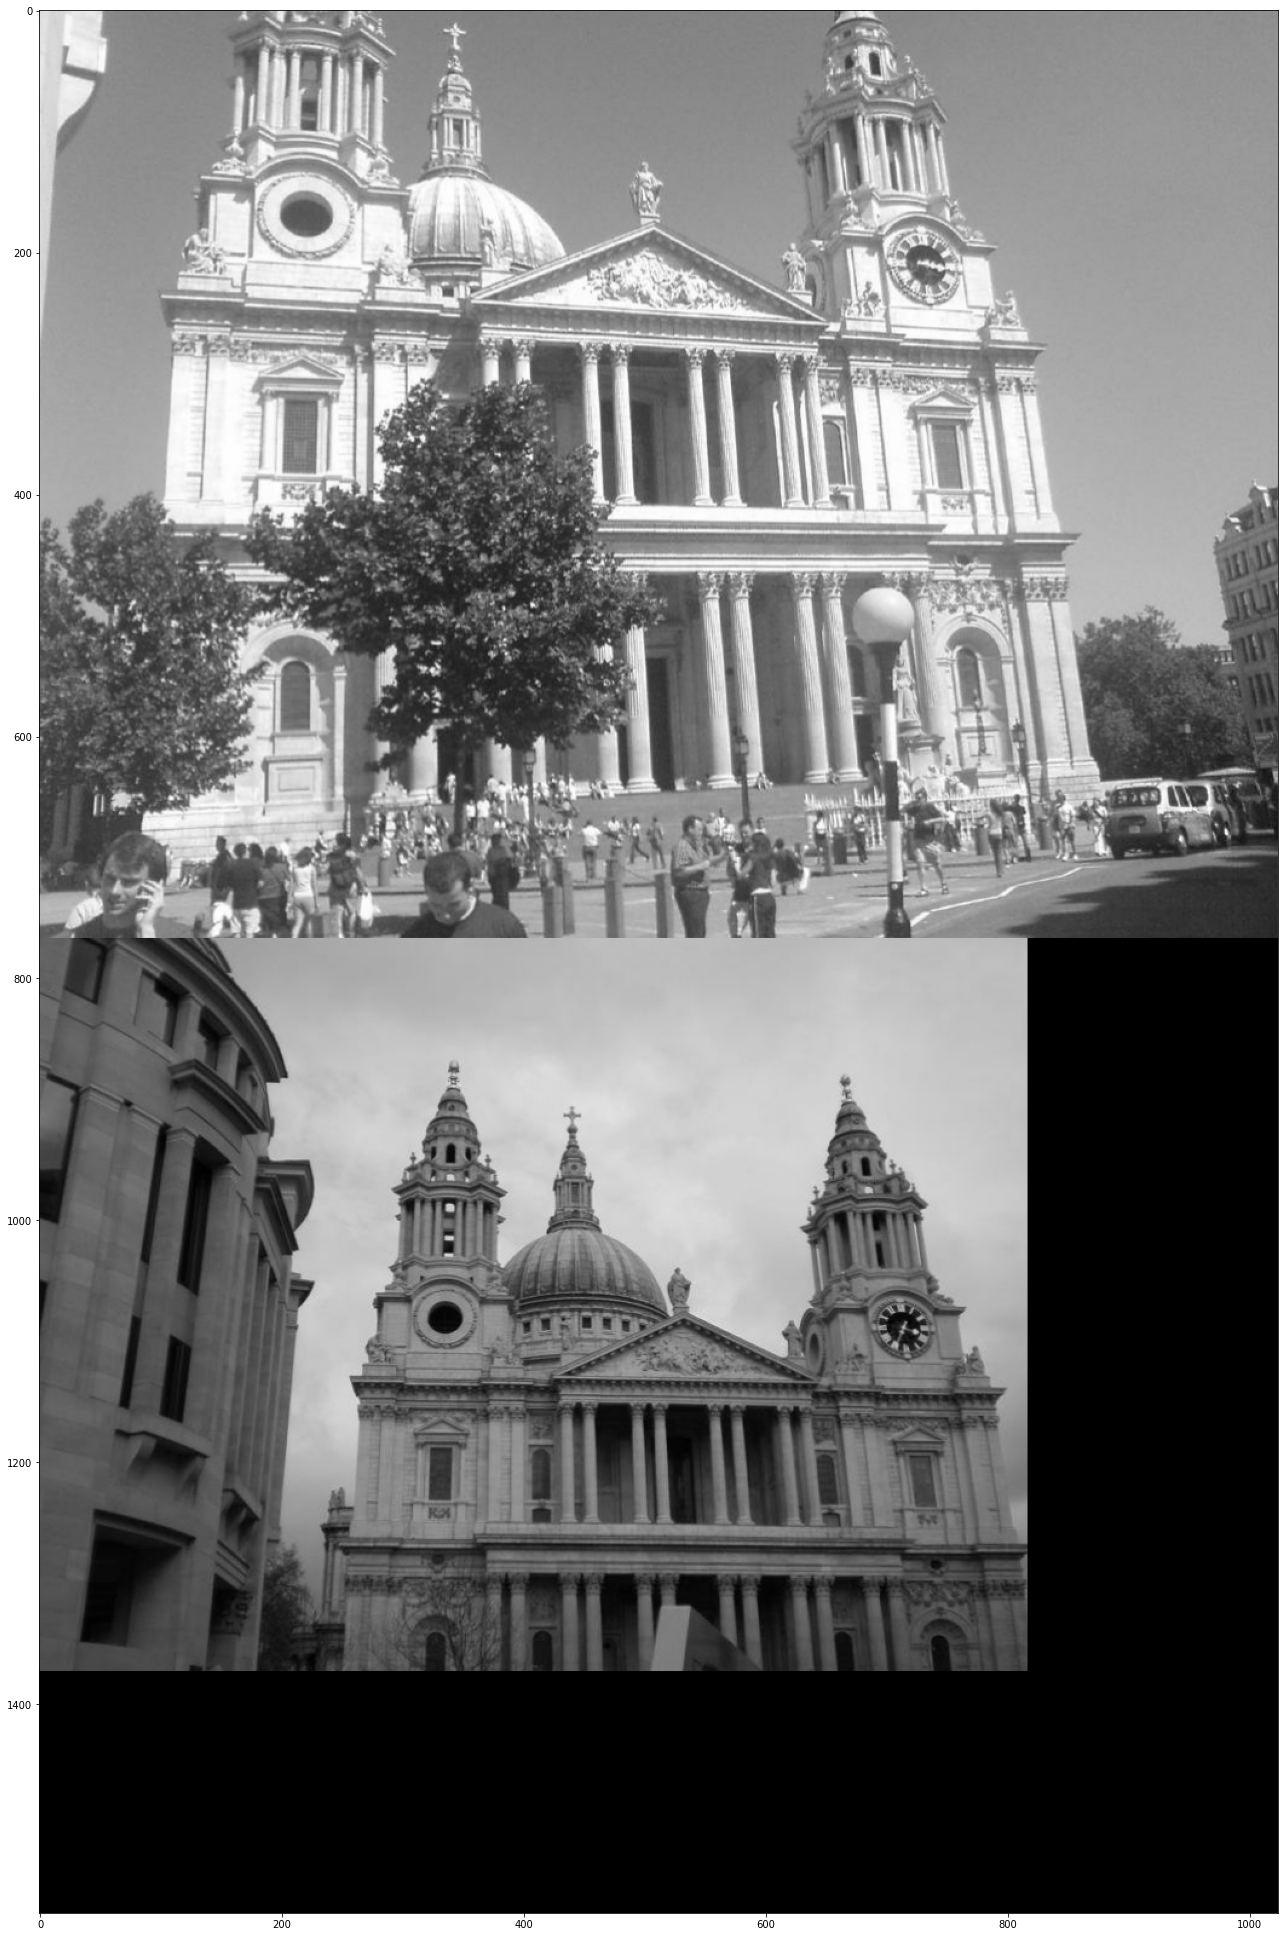

In [45]:
import matplotlib.pyplot as plt
img = output[:,:]
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
for i, ind1 in enumerate(first_ind):
    try:
        r = np.random.randint(255)
        g = np.random.randint(255)
        b = np.random.randint(255)
        img = cv2.line(img, (first_ind[i][1], first_ind[i][0]), (second_ind[i][1], second_ind[i][0] + offset), (r,g,b), 1)
    except KeyError:
        continue
#img = cv2.line(img, (0,0), (1600, 60), (0,0,0), 10)
plt.rcParams['figure.figsize'] = [70, 35]
plt.imshow(img)